<h1>Face Recognition</h1>
<h3>This is a basic project about face recognition using tensorflow keras</h3>
In this course we will be exploring the use of tensorflow keras for face recognising.

Face recognition is another form of image classification task called the one-shot classification. In real life situation, it is not always practical to have multiple images of the same person. Sometimes all that we have is one image of the person and we have to decide if the face presented is the person or not. Thus the name one-shot classification come about. In this case, we do not have enough data for a normal image classification model utilises convolution layers to fully learn the feature of a person, thus we resort to train another model focusing on outputing the similarity between 2 images, namely the siamese network.

This process is particularly useful in various applications such as security, attendance taking, text similarity, where limited amount of data about a person is given and classifications needs to be done.

We will implement this project from scratch and take small steps to ensure understanding.

<h3>Objectives:</h3>

1. Setting up environment
2. Select datasets
3. Dataset processing
4. Siamese Network Modeling

    i.  Training & Validation

    ii. Performance testing
    
5. Siamese Contrastive Model

    i.  Training & Validation

    ii. Performance testing
    
6. Siamese Cosine Similarity Model

    i.  Training & Validation

    ii. Performance testing
    

<h3>Section 1: Setting Up Environment</h3>

**For this project, we are using Python 3.11.7, aloneside with the following packages:**

1. tensorflow = ^2.15.0
2. keras = ^2.15.0
3. tensorboard = ^2.15.0
4. numpy = ^1.26.3
5. matplotlib = ^3.8.2
6. scikit-learn = ^1.3.2

**Use !pip install (package_name) if you do not have the packages**

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import shutil
import keras
import time
import cv2
from sklearn.model_selection import train_test_split

<h3>Section 2: Select Datasets</h3>

**For this task, we choose the labeled faces in the wild dataset from kaggle (https://vis-www.cs.umass.edu/lfw/#download)**

**After downloaded the dataset, rename it and move it to a folder that you prefer**

**The dataset contains images of over 5000 people, but only some have more than 1 photos**

**After importing the dataset, we first check the number of people present in the dataset.**

In [ ]:
data_folder = 'lfw-deepfunneled'
subfolders = [x[0] for x in os.walk(data_folder)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

**To get a hang of the dataset, we loop through the subfolders and acquire the name, number of photos available for each person.**

In [22]:
people_list = []

for path in subfolders:
    image_count = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    people_list.append((path.split('\\')[-1], image_count))  # append a tuple of the person's name and the number of images of them


people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

**We can print out the information to visualise the data better**

In [23]:
print(f'Number of people: {len(subfolders)}')
print(f'Number of people with only one photo: {len([person for person, image_count in people_list if image_count==1])}')
print(f'Number of people with >=5 photos: {len([person for person, image_count in people_list if image_count>=5])}')

Number of people: 5749
Number of people with only one photo: 4069
Number of people with >=5 photos: 423


<h3>Section 3: Dataset Processing</h3>

**To prepare appropriate dataset for siamese network, we need to group the images in triplets of anchor, positive_image, negative_image.**



**First we filter out all people that has more than 5 images by copying them to a seperate folder.**

In [24]:
selected_persons = {}
i = 0

for person,image_count in people_list:
    if image_count >=5:
        file_list = []
        
        # create new folder in selected images path
        newpath = 'more_than_5' + '/' + person.split('/')[-1]
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        # copy / paste first 5 images to the new location
        files = [os.path.join(person, f) for f in os.listdir(person) if os.path.isfile(os.path.join(person, f))]
        files = files[0:5] # select first 5 images
        for file in files:
            filename = file.split('/')[-1]
            shutil.copyfile(file, newpath + '/' + filename)
            file_list.append(newpath + '/' + filename)
            
        selected_persons[i] = file_list
        i = i + 1

**Now we can create our triplet by choosing any image as anchor, an image of the same person as positive image, and an image of a different person as negative image.**

In [25]:
triplets = []

for item in selected_persons.items():
    images = item[1]
    
    for i in range(len(images)-1):
        for j in range(i+1,len(images)):
            anchor = images[i]
            positive = images[j]
            
            # choose a random negative
            # first generate a random class rank and make sure we're not selecting the current class
            random_class = item[0]
            while random_class == item[0]:
                random_class = random.randint(0, len(selected_persons)-1)
            # selected a random image from the 5 that any of our classes has
            random_image = random.randint(0, 4)
            negative = selected_persons[random_class][random_image]
            
            triplets.append((anchor, positive, negative))

triplets

[('more_than_5/George_W_Bush/George_W_Bush_0387.jpg',
  'more_than_5/George_W_Bush/George_W_Bush_0393.jpg',
  'more_than_5/Kofi_Annan/Kofi_Annan_0009.jpg'),
 ('more_than_5/George_W_Bush/George_W_Bush_0387.jpg',
  'more_than_5/George_W_Bush/George_W_Bush_0378.jpg',
  'more_than_5/Robert_Mueller/Robert_Mueller_0004.jpg'),
 ('more_than_5/George_W_Bush/George_W_Bush_0387.jpg',
  'more_than_5/George_W_Bush/George_W_Bush_0422.jpg',
  'more_than_5/William_Donaldson/William_Donaldson_0004.jpg'),
 ('more_than_5/George_W_Bush/George_W_Bush_0387.jpg',
  'more_than_5/George_W_Bush/George_W_Bush_0344.jpg',
  'more_than_5/David_Anderson/David_Anderson_0003.jpg'),
 ('more_than_5/George_W_Bush/George_W_Bush_0393.jpg',
  'more_than_5/George_W_Bush/George_W_Bush_0378.jpg',
  'more_than_5/Jackie_Chan/Jackie_Chan_0001.jpg'),
 ('more_than_5/George_W_Bush/George_W_Bush_0393.jpg',
  'more_than_5/George_W_Bush/George_W_Bush_0422.jpg',
  'more_than_5/John_Snow/John_Snow_0016.jpg'),
 ('more_than_5/George_W_Bush

**Now the triplets are just path to all the images, we can define a function that access the path and return images that is preprocessed.**

In [26]:
target_size = (256, 256)

def preprocess_image(filename):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_size)
    return image

**We can define a function to visualise the triplets**

In [27]:
def plot_images(triplets):
    def show(axis, image):
        axis.imshow(image)
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)
    
    fig = plt.figure(figsize=(7,12))
    axis = fig.subplots(5, 3)
    
    for i in range(0,5):
        anchor,positive,negative = triplets[i+15]
        show(axis[i,0], preprocess_image(anchor))
        show(axis[i,1], preprocess_image(positive))
        show(axis[i,2], preprocess_image(negative))

**Let us take a look at the triplets**

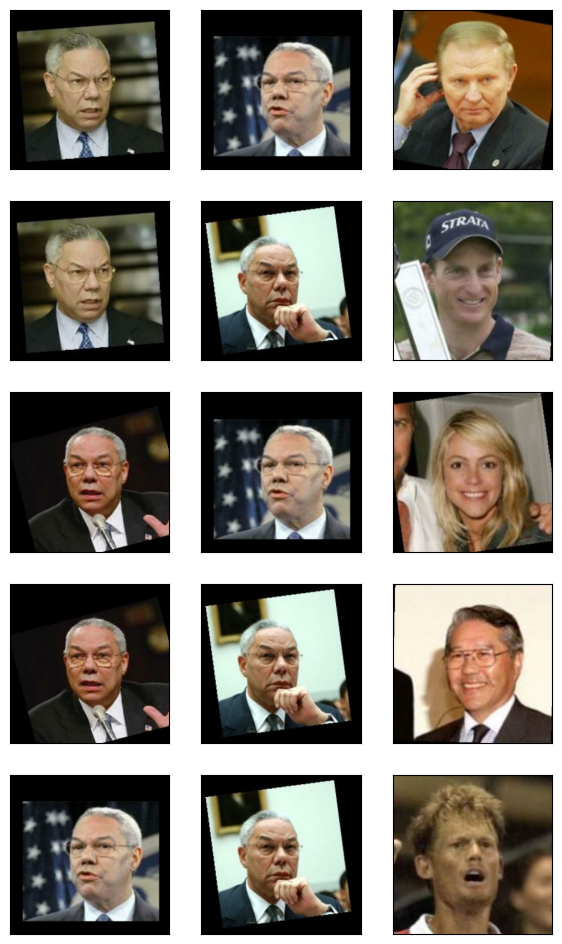

In [28]:
plot_images(triplets)

**Utilising the preprocess_image function that we defined, we can take the triplets path and return the corresponding images.**

In [29]:
def preprocess_triplets(anchor, positive, negative):

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative)
    )

**Now the triplets are still in order that the are created, we can randomise the order to prevent our neural network from drawing unnecessary relations.**

In [30]:
rng = np.random.RandomState(seed=101)
rng.shuffle(triplets)

**Now we prepare our datasets using all the functions we define.**

In [31]:
anchor_images = [a_tuple[0] for a_tuple in triplets]
positive_images = [a_tuple[1] for a_tuple in triplets]
negative_images = [a_tuple[2] for a_tuple in triplets]

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

**We can split the dataset to training and testing.**

In [32]:
training_data = dataset.take(round(image_count * 0.8))
validation_data = dataset.skip(round(image_count * 0.8))

training_data = training_data.batch(32, drop_remainder=False).prefetch(8)
validation_data = validation_data.batch(32, drop_remainder=False).prefetch(8)

<h3>Section 4: Siamese Network Modeling</h3>

<h4>Section 4i: Training & Validation</h4>

**Siamese network is a network specific in doing one-shot predictions. It takes in multuiple inputs and calculates the eucleadean distance between their embeddings.**

**In an ideal situation, the distance between the anchor and positive image should be small and the distance between the anchor and negative image should be large.**

**First we construct our neural network that has a few convolutional networks that returns the embedding of the input images.**

In [33]:
input = keras.Input(name='anchor', shape=(256, 256, 3))


def CNN_Block(depth,filter,local_response_normalization):
    
    if local_response_normalization:
        return keras.Sequential([keras.layers.Conv2D(depth, filter),keras.layers.ReLU(),keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x))])
    else:
        return keras.Sequential([keras.layers.Conv2D(depth, filter),keras.layers.ReLU()])

embedding_model = keras.Sequential([keras.layers.Reshape((256, 256, 3), input_shape=(256, 256, 3)),
                                    CNN_Block(depth=32, filter=(11,11), local_response_normalization=True), keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                    CNN_Block(depth=64, filter=(5,5), local_response_normalization=True), keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                    keras.layers.Dropout(0.5),
                                    CNN_Block(depth=128, filter=(3,3), local_response_normalization=False),
                                    CNN_Block(depth=256, filter=(3,3), local_response_normalization=False),
                                    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
                                    keras.layers.Dense(1024,activation='relu'),
                                    keras.layers.Dropout(0.5),
                                    keras.layers.Dense(128,activation='relu')
                                    ])

embeddeding = embedding_model(input)


siamese_model = keras.Model(inputs=[(input)], outputs=embeddeding)


**We need a custom loss function for our problem. For siamese model, we need a triplet loss with the aim to maximise the distance between anchor and negative_image and minimise the distance between anchor and positive_image.**

**Our function takes in the embedding for each image and calculates the eucleadean distance between them, the loss is defined as positive distance - negative distance since positive distance is suppose to be smaller.**

**As we want the positive image to be even smaller than negative distance, we can introduce a hard margin ensuring that there is still a loss even when positive distance is smaller, making the neural network trys to further the difference between the distances.**

In [34]:
def triplet_loss(margin, embeddeding_anchor, embeddeding_positive, embeddeding_negative):
    positive_distance = tf.reduce_mean(tf.square(embeddeding_anchor - embeddeding_positive), axis=1)
    negative_distance = tf.reduce_mean(tf.square(embeddeding_anchor - embeddeding_negative), axis=1)
    return tf.maximum(tf.reduce_mean(positive_distance - negative_distance) + margin, 0.0)

**We choose the adam optimiser with a low learning_rate.**

In [35]:
siamese_optimizer = keras.optimizers.legacy.Adam(0.0001)

**As our loss function is customised and takes in different inputs to generate output, we need a custom training step to update our parameters in the model.**

**We need a custom validation step to determine the effectveness of the model as well, in this case i choose to show the different between the 2 differences, the higher the better.**
 

In [36]:
@tf.function
def train_step(siamese_model, triplets, margin, loss = triplet_loss):
    # siamese_optimizer.learning_rate.assign(LEARNING_RATE)
    with tf.GradientTape() as tape:
        loss = loss(margin, siamese_model(triplets[0]), siamese_model(triplets[1]), siamese_model(triplets[2]))
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    siamese_optimizer.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    return loss

@tf.function
def test_step(siamese_model, triplets):
    positive_distance = tf.reduce_mean(tf.square(siamese_model(triplets[0]) - siamese_model(triplets[1])), axis=1)
    negative_distance = tf.reduce_mean(tf.square(siamese_model(triplets[0]) - siamese_model(triplets[2])), axis=1)
    return tf.reduce_mean(negative_distance - positive_distance)

**We can define our custom fit function that takes in parameters like number of episodes and training datas and call our training step to train the model.**

In [37]:
def fit(training_data,validation_data,margin,steps,model=siamese_model):
    start = time.time()
    current = time.time()
    history = {'loss':[], 'val_performance':[]}
    losses = []
    for step in range(steps): 
        for triplets_batch in training_data:
            loss = train_step(model, triplets_batch, margin)
            losses.append(loss)
        
        if step % 1000 == 0 and step != 0:
            average_loss = np.mean(losses)
            valid_indicator = []
            for triplets in validation_data:
                performance = test_step(model, triplets)
                valid_indicator.append(loss)
            average_valid_performance = np.mean(performance)
            print(f" Step: {step}, Average Loss: {average_loss}, Validation Performance: {average_valid_performance}")
            print(f"Time taken for 1000 steps: {time.time() - current:.2f} seconds\n")
            history['loss'].append(average_loss)
            history['val_performance'].append(average_valid_performance)
            average_loss = []
            current = time.time()
            
        if step % 100 == 0:
            print(".", end="", flush=True)
            
        # if step % 4 == 0:
        #     LEARNING_RATE = LEARNING_RATE * decay
            
    
    print(f"Total time taken for {steps} steps: {time.time() - start:.2f} seconds")
    return history

**Let us fit the model for 50k steps.**

In [25]:
history = fit(training_data,validation_data,margin=0.3, steps=50001)

..........Step: 1000, Average Loss: 0.2855185568332672, Validation Performance: 0.03680459409952164
Time taken for 1000 steps: 441.06 seconds

..........Step: 2000, Average Loss: 0.27536916732788086, Validation Performance: -0.03190361335873604
Time taken for 1000 steps: 391.56 seconds

..........Step: 3000, Average Loss: 0.26151254773139954, Validation Performance: 0.11395621299743652
Time taken for 1000 steps: 390.63 seconds

..........Step: 4000, Average Loss: 0.25217941403388977, Validation Performance: 0.09160437434911728
Time taken for 1000 steps: 390.59 seconds

..........Step: 5000, Average Loss: 0.24263320863246918, Validation Performance: -0.035699520260095596
Time taken for 1000 steps: 384.87 seconds

..........Step: 6000, Average Loss: 0.23616445064544678, Validation Performance: 0.11736812442541122
Time taken for 1000 steps: 437.31 seconds

..........Step: 7000, Average Loss: 0.23045870661735535, Validation Performance: 0.2661913335323334
Time taken for 1000 steps: 416.70 

**Save the model for future referencing.**

In [47]:
# siamese_model.save('siamese_model.keras')
siamese_model.load_weights('siamese_model.keras')

**We can plot the validation performance and training loss to visualise exactly how our models train.**

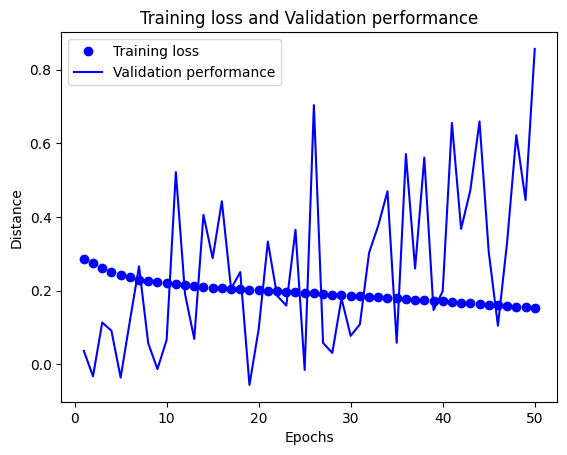

In [26]:
import matplotlib.pyplot as plt

loss = history['loss']
performance = history['val_performance']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, performance, 'b', label='Validation performance')
plt.title('Training loss and Validation performance')
plt.xlabel('Epochs')
plt.ylabel('Distance')
plt.legend()

<h4>Section 4ii: Performance Validation</h4>

**Let us test our model by putting it into use. Imagine someone came to the security of company A, asking to enter**

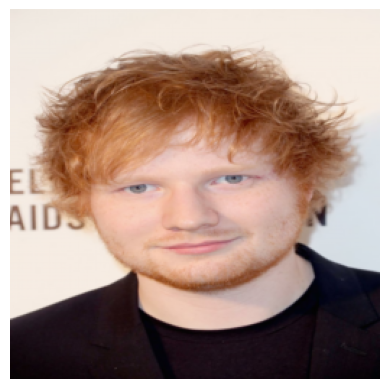

In [112]:
img = tf.io.read_file('Person of Interest.jpg')
img = tf.io.decode_jpeg(img, channels = 3) 
img = tf.image.resize(img, size = (256, 256), antialias = True)  
POI_img = img / 255.0
plt.imshow(POI_img)
plt.axis('off')
plt.show()

**In the company's record there're 6 employees, each having 1 photo.**

Ed Sheeran.jpg
Rihanna.jpg
JJ Lin.jpg
Jay Chou.jpg
Kelvin Hart.jpg
Taylor Swift.jpg


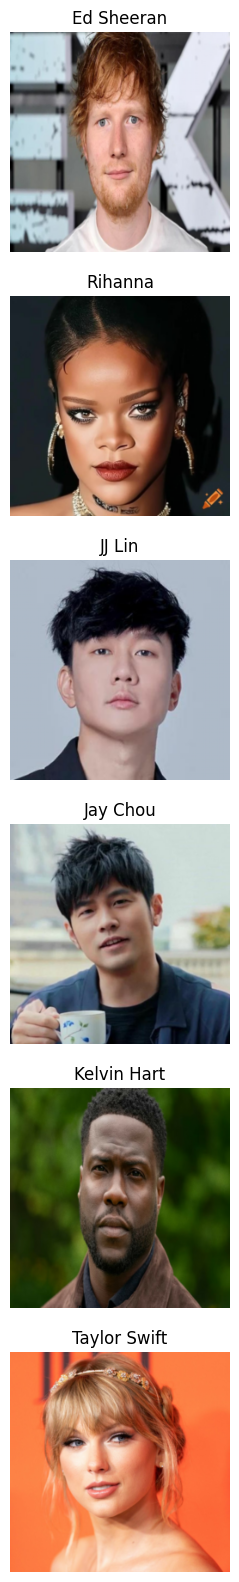

In [113]:
facebank_folder = 'Face Bank'
faces = os.listdir(facebank_folder)
faces = [face for face in faces if face.endswith('.jpg')]

fig, axs = plt.subplots(6, 1, figsize=(20, 20))

face_bank = {}
for face in faces:
    name = face.split('.')[0]
    print(face)
    img = tf.io.read_file(facebank_folder + '/' + face)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (256, 256), antialias = True)
    img = img / 255.0
    face_bank[name] = img
    axs[faces.index(face)].imshow(img)
    axs[faces.index(face)].axis('off')
    axs[faces.index(face)].set_title(name)


**We can compare the distance between the embedding of POI person and the embedding of each photos in the company's recording, finding the smallest distance.**

In [48]:
POI_embedding = siamese_model.predict(tf.expand_dims(POI_img, axis=0))[0]

for name, face in face_bank.items():
    embedding = siamese_model.predict(tf.expand_dims(face, axis=0))[0]
    distance = tf.reduce_mean(tf.square(POI_embedding - embedding))
    print(f'Name: {name}, Distance: {distance}')


1/1 [==============================] - 0s 24ms/step
Name: Ed Sheeran, Distance: 5.479314804077148
1/1 [==============================] - 0s 24ms/step
Name: Rihanna, Distance: 5.922028541564941
1/1 [==============================] - 0s 24ms/step
Name: JJ Lin, Distance: 5.004090785980225
1/1 [==============================] - 0s 24ms/step
Name: Jay Chou, Distance: 6.0492634773254395
1/1 [==============================] - 0s 23ms/step
Name: Kelvin Hart, Distance: 5.054294109344482
1/1 [==============================] - 0s 24ms/step
Name: Taylor Swift, Distance: 5.599768161773682


<h3>Section 5: Siamese contrastive loss model</h3>

<h4>Section 5i: Training & Validation</h4>

**The previous model have some problem. While it is a good idea to find the distance between 2 image, but we cannot tell the threshold distance such that images smaller than the said threshold will be consider as the same person.**

**In this section, we will be exploring another way of implementing siamese model. Instead of outputing the embedding vector and calculate the triplet loss, siamese contrastive loss model will take the embedding into another round of neural network and output a probability just like any classification model. We will define a custom contrastive loss that works similarly to a categorical cross entropy loss to train this model.**

**To prepare data for contrastive model, we just need labeled pairs as our training data instead of triplets.**

**We will leverage on the more than 5 data folder we created and generate new training data from it.**


In [2]:
file_path = 'more_than_5'
subfolders = [x[0] for x in os.walk(file_path)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

'more_than_5'

**We will pair every images in the subfolders with all other images in the subfolder, effectively generate 10 different similar pairs per person, and giving each pair a label of 0 representing similar.**

In [3]:
image_pairs = []
labels = []
for file in subfolders:
    images = [os.path.join(file, f) for f in os.listdir(file) if os.path.isfile(os.path.join(file, f))]
    for i in range(4):
        image_pairs.append([images[i], images[i+1]])
        labels.append(0)
    for i in range(3):
        image_pairs.append([images[i], images[i+2]])
        labels.append(0)
    for i in range(2):
        image_pairs.append([images[i], images[i+3]])
        labels.append(0)
    for i in range(1):
        image_pairs.append([images[i], images[i+4]])
        labels.append(0)

**We can count the number of 0s for the total number of data pairs in the dataset currently.**

In [4]:
count_ones = labels.count(0)
count_ones

4230

**To generate pairs of different people, we use the original data folder**

In [5]:
data_folder = 'lfw-deepfunneled'
subfolders = [x[0] for x in os.walk(data_folder)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

'lfw-deepfunneled'

**We import all images in the folder to our temporary dataset, labeled by the name of the person that the picture belongs to**

In [6]:
dataset = []
for path in subfolders:
    images = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    for image in images:
        dataset.append((image, path.split('/')[-1]))
        
dataset = sorted(dataset, key=lambda x: x[1])

**Since we have around 4350 similar sample, we can randomly take another 4500 images pairs from the dataset imported, it is to keep the class balancing and account for the small chances that we might get a similar pair.**

In [7]:
# Assuming your dataset is stored in the variable 'dataset'
for i in range(4500):
    random_person = random.choice(dataset)
    random_image = random_person[0]
    random_person_name = random_person[1]
    
    random_persons = [person for person in dataset if person[1] != random_person_name]
    random_person_1 = random.choice(random_persons)
    random_image_negative = random_person_1[0]
    random_person_name_negative = random_person_1[1]
    
    if random_person_name == random_person_name_negative:
        labels.append(0)
    
    else:
        labels.append(1)    #Image pair of different person will have a label of 1
    
    image_pairs.append([random_image, random_image_negative])

**Now let us take a look at the training data we will be using**

In [8]:
image_pair = np.array(image_pairs)
label = np.array(labels)

print(image_pair.shape, label.shape)

(8730, 2) (8730,)


**8730 is a decent sized number, we will proceed to randomise the order**

In [9]:
# Combine the image pairs and labels into a single list
data = list(zip(image_pairs, labels))

# Randomly shuffle the data
random.shuffle(data)

# Separate the shuffled image pairs and labels
shuffled_image_pairs, shuffled_labels = zip(*data)

# Print the shuffled image pairs and labels
print(shuffled_image_pairs)
print(shuffled_labels)


(['more_than_5/Jim_Furyk/Jim_Furyk_0001.jpg', 'more_than_5/Jim_Furyk/Jim_Furyk_0005.jpg'], ['lfw-deepfunneled/Bill_Graham/Bill_Graham_0005.jpg', 'lfw-deepfunneled/Lutz_Freitag/Lutz_Freitag_0001.jpg'], ['lfw-deepfunneled/Job_Cohen/Job_Cohen_0001.jpg', 'lfw-deepfunneled/Andy_Roddick/Andy_Roddick_0010.jpg'], ['more_than_5/Yao_Ming/Yao_Ming_0005.jpg', 'more_than_5/Yao_Ming/Yao_Ming_0004.jpg'], ['lfw-deepfunneled/Annette_Bening/Annette_Bening_0002.jpg', 'lfw-deepfunneled/George_W_Bush/George_W_Bush_0455.jpg'], ['more_than_5/Yasser_Arafat/Yasser_Arafat_0008.jpg', 'more_than_5/Yasser_Arafat/Yasser_Arafat_0001.jpg'], ['lfw-deepfunneled/Ed_Book/Ed_Book_0001.jpg', 'lfw-deepfunneled/Debra_Rose/Debra_Rose_0001.jpg'], ['lfw-deepfunneled/Mary_Frances_Seiter/Mary_Frances_Seiter_0001.jpg', 'lfw-deepfunneled/Jacques_Chirac/Jacques_Chirac_0025.jpg'], ['more_than_5/Mark_Philippoussis/Mark_Philippoussis_0009.jpg', 'more_than_5/Mark_Philippoussis/Mark_Philippoussis_0005.jpg'], ['more_than_5/Juan_Pablo_Mont

**and split the data into train and test sets**

In [10]:
X_train_path, X_test_path, y_train, y_test = train_test_split(shuffled_image_pairs, shuffled_labels, test_size=0.2, random_state=42)

**The training and testing sets still contains the path to the images for now, we have to do the necessary preprocessing to ensure an appropriate neural network input.**

In [11]:
X_train_1 = []
X_train_2 = []
X_test_1 = []
X_test_2 = []

for pair in X_train_path:
    img1 = tf.io.read_file(pair[0])
    img1 = tf.io.decode_jpeg(img1, channels = 3)
    img1 = tf.image.resize(img1, size = (256, 256), antialias = True)
    img1 = img1 / 255.0
    X_train_1.append(img1)
    
    img2 = tf.io.read_file(pair[1])
    img2 = tf.io.decode_jpeg(img2, channels = 3)
    img2 = tf.image.resize(img2, size = (256, 256), antialias = True)
    img2 = img2 / 255.0
    X_train_2.append(img2)

for pair in X_test_path:
    img1 = tf.io.read_file(pair[0])
    img1 = tf.io.decode_jpeg(img1, channels = 3)
    img1 = tf.image.resize(img1, size = (256, 256), antialias = True)
    img1 = img1 / 255.0
    X_test_1.append(img1)

    img2 = tf.io.read_file(pair[1])
    img2 = tf.io.decode_jpeg(img2, channels = 3)
    img2 = tf.image.resize(img2, size = (256, 256), antialias = True)
    img2 = img2 / 255.0
    X_test_2.append(img2)    
    

X_train_1 = np.array(X_train_1).astype('float32')
X_train_2 = np.array(X_train_2).astype('float32')
X_test_1 = np.array(X_test_1).astype('float32')
X_test_2 = np.array(X_test_2).astype('float32')
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

**Let us do some modification to our neural networks, further taking in the embedded distance and output a probability**

In [57]:
input = keras.Input(name='input', shape=(256, 256, 3))

def CNN_Block(depth,filter,local_response_normalization):
    
    if local_response_normalization:
        return keras.Sequential([keras.layers.Conv2D(depth, filter),keras.layers.ReLU(),keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x))])
    else:
        return keras.Sequential([keras.layers.Conv2D(depth, filter),keras.layers.ReLU()])

embedding_model = keras.Sequential([keras.layers.Reshape((256, 256, 3), input_shape=(256, 256, 3)),
                                    CNN_Block(depth=32, filter=(11,11), local_response_normalization=True), keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                    CNN_Block(depth=64, filter=(5,5), local_response_normalization=True), keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
                                    keras.layers.Dropout(0.5),
                                    CNN_Block(depth=128, filter=(3,3), local_response_normalization=False),
                                    CNN_Block(depth=256, filter=(3,3), local_response_normalization=False),
                                    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
                                    keras.layers.Dense(1024,activation='LeakyReLU', kernel_initializer='he_normal'),
                                    keras.layers.Dropout(0.5),
                                    keras.layers.Dense(128,activation='ReLU', kernel_initializer='he_normal')
                                    ])

embeddeding_block = keras.Model(input, embedding_model(input))

input_1 = keras.Input(name='input_1', shape=(256, 256, 3))
input_2 = keras.Input(name='input_2', shape=(256, 256, 3))

embeddeding_1 = embeddeding_block(input_1)
embeddeding_2 = embeddeding_block(input_2)

def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = tf.reduce_sum(tf.square(vector1 - vector2), axis=1, keepdims=True)
    return tf.sqrt(sum_square)

merged_vector = keras.layers.Lambda(euclidean_distance)([embeddeding_1, embeddeding_2])
normalising_layer = keras.layers.BatchNormalization()(merged_vector)
output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal')(normalising_layer)

siamese_contrastive_model = keras.Model(inputs=[input_1, input_2], outputs=output)

**We will implement a customised loss function for training**

In [58]:
def contrastive_loss(y_true, y_pred):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(1 - y_pred, 0))
    return tf.reduce_mean(y_true * margin_square + (1 - y_true) * square_pred)


**Now we have our network ready, let us run the training**

In [19]:
siamese_contrastive_optimizer = keras.optimizers.legacy.Adam(0.0001)

siamese_callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),keras.callbacks.ModelCheckpoint(filepath='siamese_contrastive_model.keras', save_best_only=True)]

Compile the model with defined loss and optimiser

In [60]:
siamese_contrastive_model.compile(loss=contrastive_loss, optimizer=siamese_contrastive_optimizer, metrics=['accuracy'])
siamese_contrastive_model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_18 (Functional)       (None, 27, 27, 128)          826304    ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda_17 (Lambda)          (None, 1, 27, 128)           0         ['model_18[0][0]',     

**We can also see the structure of the model by plotting it using keras utils**

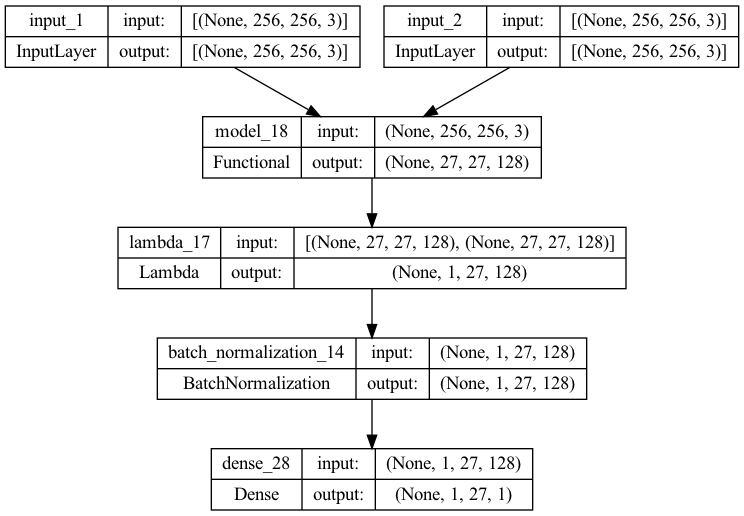

In [61]:
keras.utils.plot_model(siamese_contrastive_model, show_shapes=True)

**Fit the model with training and testing data**

In [62]:
history = siamese_contrastive_model.fit([X_train_1, X_train_2], y_train, epochs=1, batch_size=32, validation_data=([X_test_1, X_test_2], y_test), callbacks=siamese_callbacks)

219/219 [==============================] - 875s 4s/step - loss: nan - accuracy: 0.4791 - val_loss: nan - val_accuracy: 0.5063


**I stopped the training after 1 episode because we can see a very bad trend here, that is the loss is nan. This is a typical training problem call the vanishing gradient problem. A probable reason is that during training, majority of the weights are updated to 0, leaving a output close to 0, making it hard to calculate the loss function and thus backpropagation can not take place.**

**The vanishing/ exploding gradient problem often arises from a bad neural network structure. To solve the problem, we can update our model. In this case, we can save time by opting the option of transfer learning, using the ResNet model that we are familiar with.**

In [50]:
input = keras.Input(name='input', shape=(256, 256, 3))

resnet = keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=input, input_shape=(256, 256, 3), pooling='avg')

for layer in resnet.layers:
    layer.trainable = False
    
embedding = keras.models.Sequential([resnet, keras.layers.Flatten()])

x = embedding(input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)

embedding_block = keras.Model(input, x)


input_1 = keras.Input(name='input_1', shape=(256, 256, 3))
input_2 = keras.Input(name='input_2', shape=(256, 256, 3))

embedding_1 = embedding_block(input_1)
embedding_2 = embedding_block(input_2)

def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = tf.reduce_sum(tf.square(vector1 - vector2), axis=1, keepdims=True)
    return tf.sqrt(sum_square)

merged_vector = keras.layers.Lambda(euclidean_distance)([embedding_1, embedding_2])
normalising_layer = keras.layers.BatchNormalization()(merged_vector)
output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal')(normalising_layer)

siamese_resnet_model = keras.Model(inputs=[input_1, input_2], outputs=output)

**Let us compile the model again**

In [64]:
siamese_resnet_model.compile(loss=contrastive_loss, optimizer=siamese_contrastive_optimizer, metrics=['accuracy'])
siamese_resnet_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model_20 (Functional)       (None, 128)                  2414617   ['input_1[0][0]',             
                                                          6          'input_2[0][0]']             
                                                                                                  
 lambda_18 (Lambda)          (None, 1)                    0         ['model_20[0][0]',     

**Plotting the model shows similar result as the changes happened in the embeding block itself**

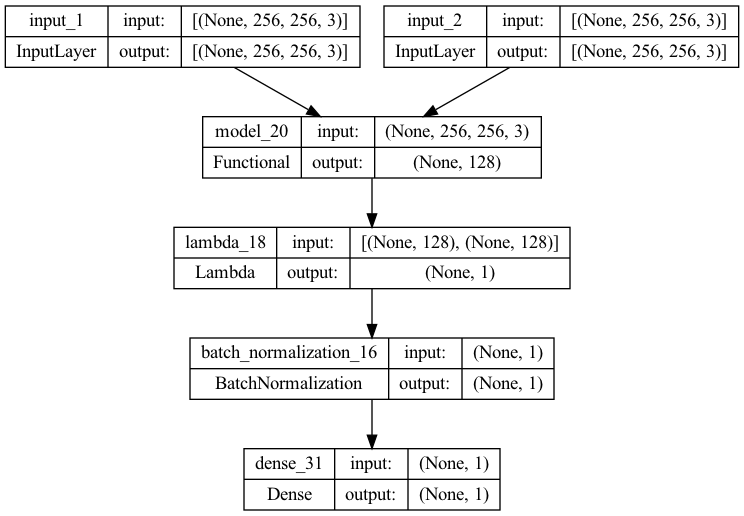

In [65]:
keras.utils.plot_model(siamese_resnet_model, show_shapes=True)

**Let us fit the model, call backs like early stopping will help us adress issues with overfitting and checkpoint will help in saving the best model**

In [66]:
history = siamese_resnet_model.fit([X_train_1, X_train_2], y_train, epochs=10, batch_size=32, validation_data=([X_test_1, X_test_2], y_test), callbacks=siamese_callbacks)

Epoch 1/10
219/219 [==============================] - 467s 2s/step - loss: 0.2475 - accuracy: 0.5690 - val_loss: 0.2474 - val_accuracy: 0.5326
Epoch 2/10
219/219 [==============================] - 450s 2s/step - loss: 0.2433 - accuracy: 0.6279 - val_loss: 0.2428 - val_accuracy: 0.6002
Epoch 3/10
219/219 [==============================] - 445s 2s/step - loss: 0.2389 - accuracy: 0.6625 - val_loss: 0.2419 - val_accuracy: 0.5699
Epoch 4/10
219/219 [==============================] - 448s 2s/step - loss: 0.2341 - accuracy: 0.6946 - val_loss: 0.2378 - val_accuracy: 0.6105
Epoch 5/10
219/219 [==============================] - 12391s 57s/step - loss: 0.2289 - accuracy: 0.7135 - val_loss: 0.2430 - val_accuracy: 0.5670
Epoch 6/10
219/219 [==============================] - 45048s 207s/step - loss: 0.2227 - accuracy: 0.7377 - val_loss: 0.2341 - val_accuracy: 0.6077
Epoch 7/10
219/219 [==============================] - 17946s 82s/step - loss: 0.2172 - accuracy: 0.7567 - val_loss: 0.2429 - val_accura

**Similarly, we can save and load our model weights for future use**

In [51]:
siamese_resnet_model.load_weights('siamese_contrastive_model.keras')

<h4>Section 5ii: Performance Visualisation</h4>

**Let us put this model to the test**

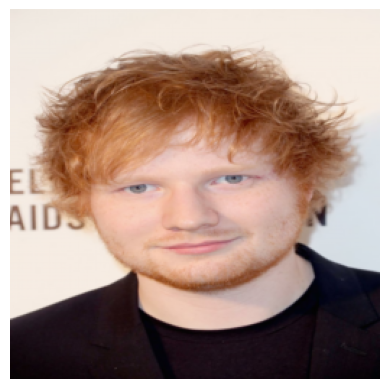

In [111]:
POI = tf.io.read_file('Person of Interest.jpg')
POI = tf.io.decode_jpeg(POI, channels = 3)
POI = tf.image.resize(POI, size = (256, 256), antialias = True)
POI = POI / 255.0
plt.imshow(POI)
plt.axis('off')
plt.show()

**Preprocess our facebank**

In [53]:
facebank_folder = 'Face Bank'
faces = os.listdir(facebank_folder)
faces = [face for face in faces if face.endswith('.jpg')]

face_bank = {}
for face in faces:
    name = face.split('.')[0]
    img = tf.io.read_file(facebank_folder + '/' + face)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (256, 256), antialias = True)
    img = img / 255.0
    face_bank[name] = img

**Since the output is a probability, we take more than 0.5 as a possible match, and the one with most probability will be displayed.**

**We can see that now the model sucessfully outputs edsheeran as the closest match, but it is still worrying that most, infact every person in the facebank were predicted with an output of more than 0.5.**

In [54]:
best_score = 0
for name, faces in face_bank.items():
    prediction = siamese_resnet_model.predict([np.expand_dims(POI, axis=0), np.expand_dims(faces, axis=0)], verbose=0)
    print(f'Name: {name}, Prediction: {prediction}')
    if prediction > 0.5 and prediction > best_score:
        match = name
        best_score = prediction
    
print(f"Welcome, {match}")

Name: Ed Sheeran, Prediction: [[0.6417122]]
Name: Rihanna, Prediction: [[0.518559]]
Name: JJ Lin, Prediction: [[0.5612277]]
Name: Jay Chou, Prediction: [[0.5313334]]
Name: Kelvin Hart, Prediction: [[0.72819877]]
Name: Taylor Swift, Prediction: [[0.65603304]]
Welcome, Kelvin Hart


<h3>Section 6: Siamese Cosine Similarity Model</h3>

<h4>Section 6i: Training & Validation</h4>

**Our last siamese model to explore is the cosine similarity model. Instead of calculating probabilities using eucleadean distance like the contrastive model, cosine similarity model calculates probability using the cosine similarity of the 2 embedings given by the dot products of the vectors devided by their normalisation.**

In [55]:
input = keras.Input(name='input', shape=(256, 256, 3))

resnet = keras.applications.ResNet101V2(include_top=False, weights='imagenet', input_tensor=input, input_shape=(256, 256, 3), pooling='avg')

for layer in resnet.layers:
    layer.trainable = False
    
embedding = keras.models.Sequential([resnet, keras.layers.Flatten()])

x = embedding(input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)

embedding_block = keras.Model(input, x)


input_1 = keras.Input(name='input_1', shape=(256, 256, 3))
input_2 = keras.Input(name='input_2', shape=(256, 256, 3))

embedding_1 = embedding_block(input_1)
embedding_2 = embedding_block(input_2)

# def euclidean_distance(vectors):
#     vector1, vector2 = vectors
#     sum_square = tf.reduce_sum(tf.square(vector1 - vector2), axis=1, keepdims=True)
#     return tf.sqrt(sum_square)

cosine_similarity = keras.layers.Dot(axes=1, normalize=True)([embedding_1, embedding_2])
out = keras.layers.Dense(256, activation='relu')(cosine_similarity)
out = keras.layers.Dropout(0.2)(out)
output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal')(out)

# merged_vector = keras.layers.Lambda(euclidean_distance)([embedding_1, embedding_2])
# normalising_layer = keras.layers.BatchNormalization()(merged_vector)
# output = keras.layers.Dense(1, activation='sigmoid', kernel_initializer='random_normal')(normalising_layer)

# siamese_resnet_model = keras.Model(inputs=[input_1, input_2], outputs=output)
cosine_similarity_model = keras.Model(inputs=[input_1, input_2], outputs=output)

**Similarly, we compile the model with a Adam optimiser of learning rate 0.0001**

In [56]:
cosine_similarity_optimizer = keras.optimizers.legacy.Adam(0.0001)

**Instead of contrastive loss, we will be using the binary cross entropy loss, treating the task as a binary classification problem**

In [20]:
cosine_similarity_model.compile(loss='binary_crossentropy', optimizer=siamese_contrastive_optimizer, metrics=['accuracy'])

**The previous model showed a trend of overfitting, and a pearly stopping patience of 5 is obviously ineffective. This time round we will let the model train for higher number of episodes, while decreasing the early stopping patience in hope to reduce overfitting.**

In [21]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),keras.callbacks.ModelCheckpoint(filepath='cosine_similarity_model.keras', save_best_only=True)]

history = cosine_similarity_model.fit([X_train_1, X_train_2], y_train, epochs=20, batch_size=32, validation_data=([X_test_1, X_test_2], y_test), callbacks=callbacks)

Epoch 1/20
219/219 [==============================] - 750s 3s/step - loss: 0.6880 - accuracy: 0.5702 - val_loss: 0.6780 - val_accuracy: 0.6363
Epoch 2/20
219/219 [==============================] - 732s 3s/step - loss: 0.6661 - accuracy: 0.6667 - val_loss: 0.6547 - val_accuracy: 0.6741
Epoch 3/20
219/219 [==============================] - 745s 3s/step - loss: 0.6367 - accuracy: 0.7153 - val_loss: 0.6300 - val_accuracy: 0.7085
Epoch 4/20
219/219 [==============================] - 743s 3s/step - loss: 0.5975 - accuracy: 0.7756 - val_loss: 0.5981 - val_accuracy: 0.7457
Epoch 5/20
219/219 [==============================] - 732s 3s/step - loss: 0.5455 - accuracy: 0.8352 - val_loss: 0.5576 - val_accuracy: 0.7869
Epoch 6/20
219/219 [==============================] - 735s 3s/step - loss: 0.4808 - accuracy: 0.8889 - val_loss: 0.5183 - val_accuracy: 0.7915
Epoch 7/20
219/219 [==============================] - 730s 3s/step - loss: 0.4118 - accuracy: 0.9271 - val_loss: 0.4722 - val_accuracy: 0.8333

**Let us visualise our training history**

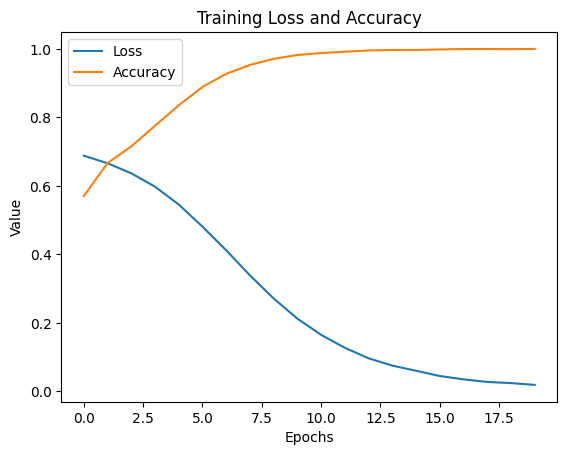

In [26]:
import matplotlib.pyplot as plt

# Get the loss and accuracy from the history
loss = history.history['loss']
accuracy = history.history['accuracy']

# Plot the loss and accuracy on one graph
plt.plot(loss, label='Loss')
plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Accuracy')
plt.legend()
plt.show()


**Saving and loading our model for future reference**

In [121]:
cosine_similarity_model.load_weights('cosine_similarity_model.keras')

<h4>Section 6ii: Performance Visualisation</h4>

**Testing the model again**

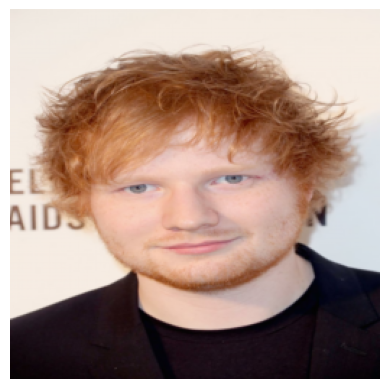

In [122]:
POI = tf.io.read_file('Person of Interest.jpg')
POI = tf.io.decode_jpeg(POI, channels = 3)
POI = tf.image.resize(POI, size = (256, 256), antialias = True)
POI = POI / 255.0

plt.imshow(POI)
plt.axis('off')
plt.show()

**We can see that our model is accurately predicting the person now. But problem persist as the model might falsefully predict Ed Sheeran as Rihanna or Kelvin Hart.**

In [123]:
faces = os.listdir('Face Bank')
faces = [face for face in faces if face.endswith('.jpg')]
best_score = 0

for face in faces:
    name = face.split('.')[0]
    img = tf.io.read_file('Face Bank/' + face)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (256, 256), antialias = True)
    img = img / 255.0
    prediction = cosine_similarity_model.predict([np.expand_dims(POI, axis=0), np.expand_dims(img, axis=0)], verbose=0)
    print(f'Name: {name}, Prediction: {prediction}')
    if prediction > 0.5 and prediction > best_score:
        match = name
        best_score = prediction

print(f"Welcome, {match}")

Name: Ed Sheeran, Prediction: [[0.8890266]]
Name: Rihanna, Prediction: [[0.7794703]]
Name: JJ Lin, Prediction: [[0.39605385]]
Name: Jay Chou, Prediction: [[0.09872262]]
Name: Kelvin Hart, Prediction: [[0.7913323]]
Name: Taylor Swift, Prediction: [[0.11125917]]
Welcome, Ed Sheeran


**Finally, let us change an approach to preparing our data by extracting only the face in images to minimise noise from the backgrounds**

**To detect and extract faces in an image, we will make use of open source face detection models, the model of interest will be the haarcascade model from openCV**

In [71]:
img = cv2.imread('Person of Interest.jpg')
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

**Using the face cascade, we can detect only the faces in the image and save them as seperate documents**

In [72]:
faces = face_cascade.detectMultiScale(img, 1.1, 4)      
"""
detectMultiScale(image, scaleFactor, minNeighbors)
image: Matrix of the type CV_8U containing an image where objects are detected.
scaleFactor: Parameter specifying how much the image size is reduced at each image scale.
minNeighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it.
Returns: rectangles containing each detected object in the format (x, y, w, h)
x stands for the x-coordinate of the top-left corner
y stands for the y-coordinate of the top-left corner
w stands for the width of the rectangle
h stands for the height of the rectangle
"""

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)  # Draw a rectangle around the face
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, (256, 256))
    cv2.imshow('Face', face)


cv2.imwrite('Detected.jpg', img) # Save the image with rectangles drawn around the face
cv2.imshow('Image', img)
cv2.waitKey(0)

32

**Now extract our face by saving only the box containing face**

In [73]:
face = face_cascade.detectMultiScale(img, 1.1, 4)

x = face[0][0]
y = face[0][1]
w = face[0][2]
h = face[0][3]

face = img[y:y+h, x:x+w]
face = cv2.resize(face, (256, 256))

cv2.imwrite('Person of Interest_FACE.jpg', face)


True

**We can use our normal tf functions to view our extracted face**

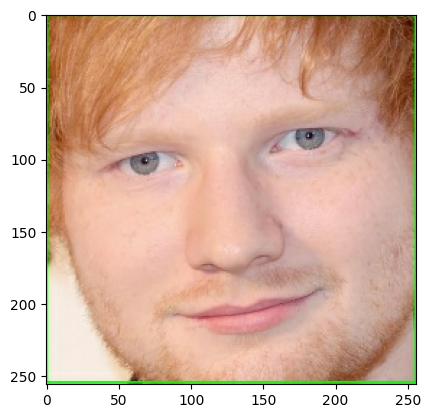

In [74]:
face = tf.io.read_file('Person of Interest_FACE.jpg')
face = tf.io.decode_jpeg(face, channels = 3)
face = tf.image.resize(face, size = (256, 256), antialias = True)
face = face / 255.0

plt.imshow(face)

**To extract all faces from our datasets, we define a function that perform the above steps to all images in the dataset**

In [36]:
def extract_faces(input_folder, output_folder):
    # Load the face cascade classifier
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

    # Get the list of image files in the input folder
    image_files = [file for file in os.listdir(input_folder) if file.endswith('.jpg')]

    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over each image file
    for image_file in image_files:
        # Read the image
        image_path = os.path.join(input_folder, image_file)
        img = cv2.imread(image_path)

        # Detect faces in the image
        faces = face_cascade.detectMultiScale(img, 1.1, 4)

        # Iterate over each detected face
        biggest_face = None
        max_area = 0
        for (x, y, w, h) in faces:
            # Extract the face region
            area = w * h
            if area > max_area:
                max_area = area
                biggest_face = (x, y, w, h)
        
        if biggest_face is not None:
            (x, y, w, h) = biggest_face
            face = img[y:y+h, x:x+w]


            # Save the extracted face to the output folder
            output_path = os.path.join(output_folder, image_file)
            cv2.imwrite(output_path, face)

    print('Face extraction completed.')
    
            


**Using the same methods as before to get a list of all subfolders in the dataset**

In [52]:
data_path = 'lfw-deepfunneled'
subfolders = [x[0] for x in os.walk(data_path)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

'lfw-deepfunneled'

**We will run each of the folder through the face extraction function**

In [53]:
for folder in subfolders:
    extract_faces(folder, 'Extracted_LFW' + '/' + folder.split('/')[-1])

Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
Face extraction completed.
F

**Now that we have our new dataset with all extracted faces, we prepare our training and testing set as usual**

In [2]:
data_folder = 'Extracted_LFW'
subfolders = [x[0] for x in os.walk(data_folder)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

'Extracted_LFW'

**Similary we generate a list with all people and the amount of images of them**

In [3]:
people_list = []

for path in subfolders:
    image_count = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    people_list.append((path.split('\\')[-1], image_count))  # append a tuple of the person's name and the number of images of them


people_list = sorted(people_list, key=lambda x: x[1], reverse=True)

**We can see that number of people with more than 5 photos actually reduces, that is because the haarcascade was not able to detect a face in certain images maybe due to lighting or angle**

In [4]:
print(f'Number of people: {len(subfolders)}')
print(f'Number of people with only one photo: {len([person for person, image_count in people_list if image_count==1])}')
print(f'Number of people with >=5 photos: {len([person for person, image_count in people_list if image_count>=5])}')

Number of people: 5749
Number of people with only one photo: 4047
Number of people with >=5 photos: 416


**We continue to filter all individuals that contains more than 5 photos**

In [5]:
selected_persons = {}
i = 0

for person,image_count in people_list:
    if image_count >=5:
        file_list = []
        
        # create new folder in selected images path
        newpath = 'extracted_5' + '/' + person.split('/')[-1]
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        
        # copy / paste first 5 images to the new location
        files = [os.path.join(person, f) for f in os.listdir(person) if os.path.isfile(os.path.join(person, f))]
        files = files[0:5] # select first 5 images
        for file in files:
            filename = file.split('/')[-1]
            shutil.copyfile(file, newpath + '/' + filename)
            file_list.append(newpath + '/' + filename)
            
        selected_persons[i] = file_list
        i = i + 1

**Getting file path for all individual's photo in the folder**

In [6]:
file_path = 'extracted_5'
subfolders = [x[0] for x in os.walk(file_path)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

'extracted_5'

**We can generate our image pairs again and give them label of 0 if similar**

In [7]:
image_pairs = []
labels = []
for file in subfolders:
    images = [os.path.join(file, f) for f in os.listdir(file) if os.path.isfile(os.path.join(file, f))]
    for i in range(4):
        image_pairs.append([images[i], images[i+1]])
        labels.append(0)
    for i in range(3):
        image_pairs.append([images[i], images[i+2]])
        labels.append(0)
    for i in range(2):
        image_pairs.append([images[i], images[i+3]])
        labels.append(0)
    for i in range(1):
        image_pairs.append([images[i], images[i+4]])
        labels.append(0)

**Getting the amount of image pairs in our dataset now**

In [8]:
count_ones = labels.count(0)
count_ones

4160

**To get none-similar pairs, we create a dataset with all images and labeled by their name**

In [9]:
data_folder = 'Extracted_LFW'
subfolders = [x[0] for x in os.walk(data_folder)]   # os.walk returns a 3-tuple (dirpath, dirnames, filenames), we only need the dirpath
subfolders.pop(0)   # remove the first element, which is the root directory itself

dataset = []
for path in subfolders:
    images = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    for image in images:
        dataset.append((image, path.split('/')[-1]))
        
dataset = sorted(dataset, key=lambda x: x[1])

'Extracted_LFW'

**Now we randomly sample the dataset for a pair, label them accordingly to their name**

In [11]:
for i in range(4200):
    random_person = random.choice(dataset)
    random_image = random_person[0]
    random_person_name = random_person[1]
    
    random_persons = [person for person in dataset if person[1] != random_person_name]
    random_person_1 = random.choice(random_persons)
    random_image_negative = random_person_1[0]
    random_person_name_negative = random_person_1[1]
    
    if random_person_name == random_person_name_negative:
        labels.append(0)
    
    else:
        labels.append(1)    #Image pair of different person will have a label of 1
    
    image_pairs.append([random_image, random_image_negative])

**Let us check our data pool now**

In [12]:
image_pair = np.array(image_pairs)
label = np.array(labels)

print(image_pair.shape, label.shape)

(8360, 2) (8360,)


**We can shuffle the data by zipping iamges and labels into 1 list and use a shuffle function to change the order**

In [13]:
data = list(zip(image_pairs, labels))

# Randomly shuffle the data
random.shuffle(data)

# Separate the shuffled image pairs and labels
shuffled_image_pairs, shuffled_labels = zip(*data)

# Print the shuffled image pairs and labels
print(shuffled_image_pairs)
print(shuffled_labels)

(['extracted_5/Martin_Scorsese/Martin_Scorsese_0004.jpg', 'extracted_5/Martin_Scorsese/Martin_Scorsese_0007.jpg'], ['extracted_5/Robert_Duvall/Robert_Duvall_0008.jpg', 'extracted_5/Robert_Duvall/Robert_Duvall_0005.jpg'], ['extracted_5/Jeremy_Greenstock/Jeremy_Greenstock_0021.jpg', 'extracted_5/Jeremy_Greenstock/Jeremy_Greenstock_0009.jpg'], ['Extracted_LFW/Roy_Jones_Jr/Roy_Jones_Jr_0002.jpg', 'Extracted_LFW/Darren_Clarke/Darren_Clarke_0001.jpg'], ['Extracted_LFW/Sharon_Davis/Sharon_Davis_0002.jpg', 'Extracted_LFW/Vitali_Klitschko/Vitali_Klitschko_0001.jpg'], ['extracted_5/Muhammad_Ali/Muhammad_Ali_0004.jpg', 'extracted_5/Muhammad_Ali/Muhammad_Ali_0010.jpg'], ['extracted_5/Hosni_Mubarak/Hosni_Mubarak_0007.jpg', 'extracted_5/Hosni_Mubarak/Hosni_Mubarak_0006.jpg'], ['Extracted_LFW/Queen_Latifah/Queen_Latifah_0003.jpg', 'Extracted_LFW/Hermes_Gamonal/Hermes_Gamonal_0001.jpg'], ['extracted_5/Holly_Hunter/Holly_Hunter_0003.jpg', 'extracted_5/Holly_Hunter/Holly_Hunter_0001.jpg'], ['Extracted_L

**Using scikit-learns' train_test_split dunction, we can split our dataset into training and testing**

In [14]:
X_train_path, X_test_path, y_train, y_test = train_test_split(shuffled_image_pairs, shuffled_labels, test_size=0.2, random_state=42)

**We now split the iamge pairs into 2 different arrays for proper input shape to be fed into neural network**

In [15]:
X_train_1 = []
X_train_2 = []
X_test_1 = []
X_test_2 = []

for pair in X_train_path:
    img1 = tf.io.read_file(pair[0])
    img1 = tf.io.decode_jpeg(img1, channels = 3)
    img1 = tf.image.resize(img1, size = (256, 256), antialias = True)
    img1 = img1 / 255.0
    X_train_1.append(img1)
    
    img2 = tf.io.read_file(pair[1])
    img2 = tf.io.decode_jpeg(img2, channels = 3)
    img2 = tf.image.resize(img2, size = (256, 256), antialias = True)
    img2 = img2 / 255.0
    X_train_2.append(img2)

for pair in X_test_path:
    img1 = tf.io.read_file(pair[0])
    img1 = tf.io.decode_jpeg(img1, channels = 3)
    img1 = tf.image.resize(img1, size = (256, 256), antialias = True)
    img1 = img1 / 255.0
    X_test_1.append(img1)

    img2 = tf.io.read_file(pair[1])
    img2 = tf.io.decode_jpeg(img2, channels = 3)
    img2 = tf.image.resize(img2, size = (256, 256), antialias = True)
    img2 = img2 / 255.0
    X_test_2.append(img2)    
    

X_train_1 = np.array(X_train_1).astype('float32')
X_train_2 = np.array(X_train_2).astype('float32')
X_test_1 = np.array(X_test_1).astype('float32')
X_test_2 = np.array(X_test_2).astype('float32')
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

**Let us update our model by calculating the similarity directly from dot product instead of connecting it through dense layer**

In [38]:
input = keras.Input(name='input', shape=(256, 256, 3))

resnet = keras.applications.ResNet101V2(include_top=False, weights='imagenet', input_tensor=input, input_shape=(256, 256, 3), pooling='avg')

for layer in resnet.layers:
    layer.trainable = False
    
embedding = keras.models.Sequential([resnet, keras.layers.Flatten()])

x = embedding(input)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation='relu')(x)

embedding_block = keras.Model(input, x)


input_1 = keras.Input(name='input_1', shape=(256, 256, 3))
input_2 = keras.Input(name='input_2', shape=(256, 256, 3))

embedding_1 = embedding_block(input_1)
embedding_2 = embedding_block(input_2)

cosine_similarity = keras.layers.Dot(axes=1, normalize=True)([embedding_1, embedding_2])

updated_cosine_similarity_model = keras.Model(inputs=[input_1, input_2], outputs=cosine_similarity)

**Compile the model using similar parameters for comparison**

In [17]:
updated_cosine_similarity_optimizer = keras.optimizers.legacy.Adam(0.0001)
updated_cosine_similarity_model.compile(loss='binary_crossentropy', optimizer=updated_cosine_similarity_optimizer, metrics=['accuracy'])

**We will use the same call backs as well**

In [18]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),keras.callbacks.ModelCheckpoint(filepath='updated_cosine_similarity_model.keras', save_best_only=True)]

**Since we have a earlystopping callback, we will set the epoch counts to 50 to ensure maximised training**

In [21]:
history = updated_cosine_similarity_model.fit([X_train_1, X_train_2], y_train, epochs=50, batch_size=32, validation_data=([X_test_1, X_test_2], y_test), callbacks=callbacks)

Epoch 1/50
209/209 [==============================] - 1111s 5s/step - loss: 0.8165 - accuracy: 0.4350 - val_loss: 0.7961 - val_accuracy: 0.4246
Epoch 2/50
209/209 [==============================] - 1052s 5s/step - loss: 0.7485 - accuracy: 0.4744 - val_loss: 0.7783 - val_accuracy: 0.4342
Epoch 3/50
209/209 [==============================] - 1038s 5s/step - loss: 0.7033 - accuracy: 0.5087 - val_loss: 0.7693 - val_accuracy: 0.4510
Epoch 4/50
209/209 [==============================] - 1060s 5s/step - loss: 0.6643 - accuracy: 0.5489 - val_loss: 0.7647 - val_accuracy: 0.4629
Epoch 5/50
209/209 [==============================] - 1057s 5s/step - loss: 0.6325 - accuracy: 0.5912 - val_loss: 0.7537 - val_accuracy: 0.4617
Epoch 6/50
209/209 [==============================] - 1072s 5s/step - loss: 0.6044 - accuracy: 0.6356 - val_loss: 0.7381 - val_accuracy: 0.4809
Epoch 7/50
209/209 [==============================] - 1094s 5s/step - loss: 0.5785 - accuracy: 0.6794 - val_loss: 0.7367 - val_accuracy:

**Saving our model for future deployment**

In [26]:
# updated_cosine_similarity_model.load_weights('updated_cosine_similarity_model.keras')

import pickle
history1 = history.history
with open('similarity_training_history.pkl', 'wb') as f:
    pickle.dump(history1, f)

**Viewing from result, the validation accuracy do show trends on increasing from the last epoch, just that it got canceled due to reaching the maximum patience of the early stopping callbacks, let us continue the trianing for a few epochs and see how it goes**

In [20]:
history_cont = updated_cosine_similarity_model.fit([X_train_1, X_train_2], y_train, epochs=20, batch_size=32, validation_data=([X_test_1, X_test_2], y_test), callbacks=callbacks)

Epoch 1/20
209/209 [==============================] - 1077s 5s/step - loss: 0.5267 - accuracy: 0.7587 - val_loss: 0.5271 - val_accuracy: 0.7392
Epoch 2/20
209/209 [==============================] - 1073s 5s/step - loss: 0.4648 - accuracy: 0.8146 - val_loss: 0.5189 - val_accuracy: 0.7524
Epoch 3/20
209/209 [==============================] - 19644s 94s/step - loss: 0.4271 - accuracy: 0.8452 - val_loss: 0.5171 - val_accuracy: 0.7542
Epoch 4/20
209/209 [==============================] - 59580s 286s/step - loss: 0.4008 - accuracy: 0.8639 - val_loss: 0.5134 - val_accuracy: 0.7560
Epoch 5/20
209/209 [==============================] - 28573s 137s/step - loss: 0.3763 - accuracy: 0.8838 - val_loss: 0.5282 - val_accuracy: 0.7518
Epoch 6/20
209/209 [==============================] - 57096s 274s/step - loss: 0.3572 - accuracy: 0.8894 - val_loss: 0.5233 - val_accuracy: 0.7566
Epoch 7/20
209/209 [==============================] - 10480s 50s/step - loss: 0.3336 - accuracy: 0.8989 - val_loss: 0.5303 - 

**We will join the histories together for clearer visualisation of training**

In [26]:
history_acc =history.history['accuracy']
history_val_acc = history.history['val_accuracy']

for i in history_cont.history['accuracy']:
    history_acc.append(i)

for i in history_cont.history['val_accuracy']:
    history_val_acc.append(i)

**Visualising trining history with matplotlib**

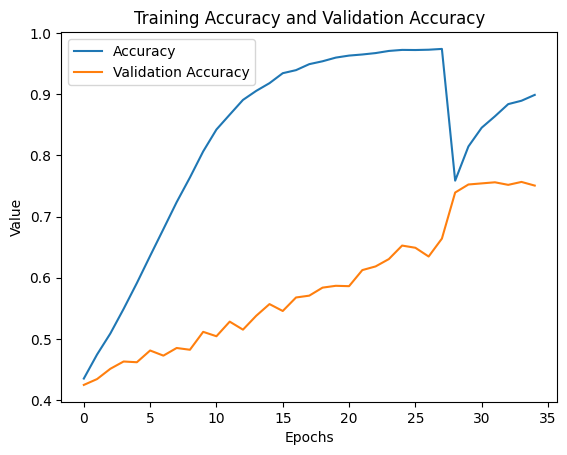

In [28]:
plt.plot(history_acc, label='Accuracy')
plt.plot(history_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Accuracy and Validation Accuracy')
plt.legend()
plt.show()

**Finally let us test the final model, using the extracted face as our new input**

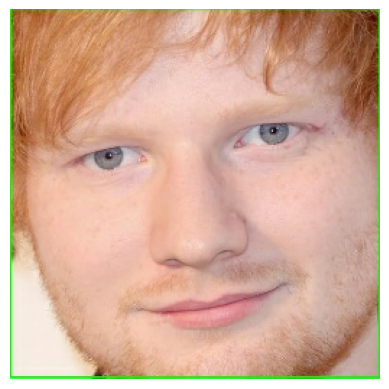

In [79]:
POI = tf.io.read_file('Person of Interest_FACE.jpg')
POI = tf.io.decode_jpeg(POI, channels = 3)
POI = tf.image.resize(POI, size = (256, 256), antialias = True)
POI = POI / 255.0

plt.imshow(POI)
plt.axis('off')
plt.show()

**We will extract all faces in our face bank as well to miximise feature extraction**

In [56]:
extract_faces('Face Bank', 'Extracted_Face_Bank')

Face extraction completed.


**Let us print out the facebank with extracted faces**

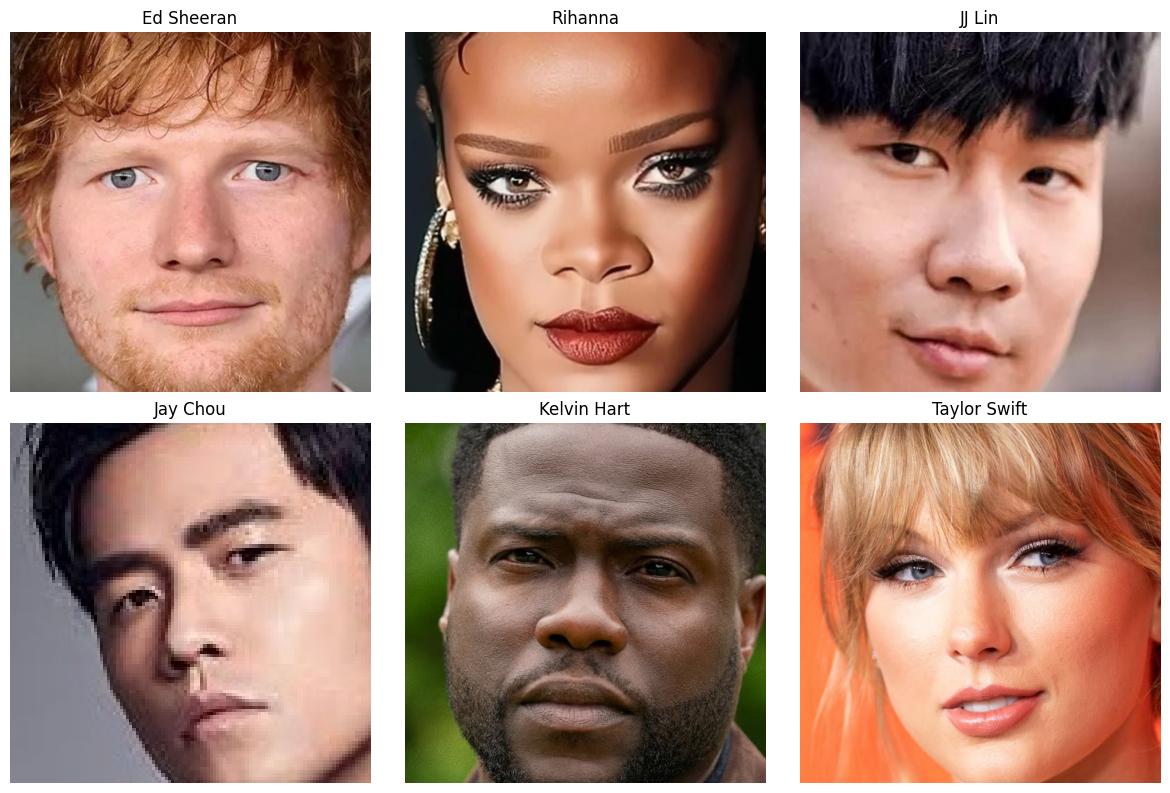

In [59]:
import matplotlib.pyplot as plt
import os

# Set the path to the 'Extracted_Face_Bank' folder
folder_path = 'Extracted_Face_Bank'

# Get the list of JPG files in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

# Create a subplot with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Iterate over the file list and plot each image
for i, file in enumerate(file_list):
    # Get the image path
    image_path = os.path.join(folder_path, file)
    
    # Read the image
    image = plt.imread(image_path)
    
    # Determine the subplot position
    row = i // 3
    col = i % 3
    
    # Plot the image in the corresponding subplot
    axs[row, col].imshow(image)
    axs[row, col].axis('off')
    axs[row, col].set_title(file.split('.')[0])
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


**Note that the output of the neural network is only the similarity between 2 images, it is not a prediction of probability.**

**We can see that this time the the prediction on Ed Sheeran being Ed Sheeran is much higher than the predicton of the rest**

In [80]:
faces = os.listdir('Extracted_Face_Bank')
faces = [face for face in faces if face.endswith('.jpg')]
best_score = 0

for face in faces:
    name = face.split('.')[0]
    img = tf.io.read_file('Extracted_Face_Bank/' + face)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (256, 256), antialias = True)
    img = img / 255.0
    prediction = updated_cosine_similarity_model.predict([np.expand_dims(POI, axis=0), np.expand_dims(img, axis=0)], verbose=0)
    print(f'Name: {name}, Prediction: {prediction}')
    if prediction > 0.1 and prediction > best_score:
        match = name
        best_score = prediction

print(f"Welcome, {match}")

Name: Ed Sheeran, Prediction: [[0.4817723]]
Name: Rihanna, Prediction: [[0.22956908]]
Name: JJ Lin, Prediction: [[0.35653892]]
Name: Jay Chou, Prediction: [[0.31757113]]
Name: Kelvin Hart, Prediction: [[0.27203563]]
Name: Taylor Swift, Prediction: [[0.35482806]]
Welcome, Ed Sheeran
